In [47]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.special import lambertw, wrightomega
from scipy.stats import norm, anderson, shapiro, kurtosis, wasserstein_distance
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

plt.rcParams["figure.figsize"] =  (10,5)

## Data preprocessing (part 6 of Quant GAN paper)

In [2]:
# load data from file 
data = pd.read_csv('sp_data.csv')
data = data[['Price']]
data.index = data.index[::-1]
data = data.iloc[::-1]
data.head(3)

,Price
0,877.52
1,907.24
2,903.80


In [3]:
# deal with commas
data['Price'] = data['Price'].apply(lambda x: float(x.replace(',', '')))
data['log_ret'] = np.log(data.Price) - np.log(data.Price.shift(1))
data = data[1:]
data.head(3)

,Price,log_ret
1,907.24,0.033307
2,903.80,-0.003799
3,919.53,0.017255


In [4]:
# Checking if dataset is stationnary as described in paper p-value is tiny, so it is stationary
adfuller(data['log_ret']) 

(-11.107317854416245,
 3.734653682901422e-20,
 24,
 2389,
 {'1%': -3.433090201041693,
  '5%': -2.862750581542575,
  '10%': -2.567414443618994},
 -15487.469588327564)

In [5]:
# normalize data
scaler = StandardScaler()
log_scaled = scaler.fit_transform(data['log_ret'].values.reshape(-1,1))
data['log_scaled'] = log_scaled

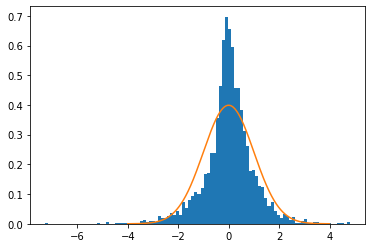

In [28]:
# plot normal bell curve for reference
x_axis = np.arange(-4, 4, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,1));

# we need to get a heavier-tail distribution
plt.hist(data['log_scaled'], bins=100, density=True);

In [832]:
# coefficient delta is estimated by taking best results according to anderson test (not sure if it is right thing to do)
# main idea is to have most normal-looking distribution as a result of transformation

In [833]:
stat = math.inf
g = 0
for delta in range(1, 20000): 
    t = np.sign(data['log_ret'])*np.sqrt((lambertw(data['log_ret']*data['log_ret']*delta)/delta)).astype(float)
    if anderson(t, dist='norm')[0] < stat:
        stat = anderson(t, dist='norm')[0]
        g = delta
    else:
        break
stat, delta

C:\Users\79222\AppData\Roaming\Python\Python37\site-packages\pandas\core\dtypes\cast.py:1201: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


(3.10409786672426, 7355)

C:\Users\79222\AppData\Roaming\Python\Python37\site-packages\pandas\core\dtypes\cast.py:1201: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


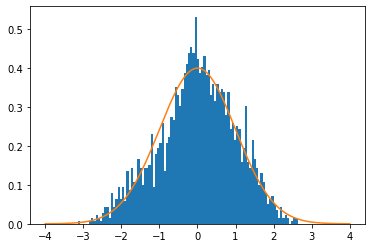

In [9]:
# now it looks like figure 10.b) from paper
# heavier tales with Gaussian-like distribution obtained
delta = 7355
t = np.sign(data['log_ret'])*np.sqrt((lambertw(data['log_ret']*data['log_ret']*delta)/delta)).astype(float)
t_scaled = scaler.fit_transform(t.values.reshape(-1,1))
data['t_scaled'] = t_scaled
plt.hist(t_scaled, bins=100, density=True);

x_axis = np.arange(-4, 4, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,1));

In [11]:
# apply rolling window of size T(d) equal to receptive field size
t_rolling = data['t_scaled'].rolling(127).mean()
data['t_rolling'] = t_rolling

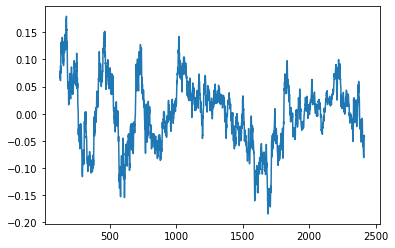

In [12]:
plt.plot(t_rolling);

## TCN

In [29]:
# Temporal convolution block based on https://arxiv.org/pdf/1803.01271.pdf
# PReLU as activation isnted of ReLU

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, padding=0, dropout=0.05):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                            padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.prelu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                        padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.prelu2 = nn.PReLU()
        self.dropout2 = nn.Dropout(dropout)

        if padding > 0:
            self.net = nn.Sequential(self.conv1, self.chomp1, self.prelu1, self.dropout1,
                                 self.conv2, self.chomp2, self.prelu2, self.dropout2)
        else:
            self.net = nn.Sequential(self.conv1,self.prelu1, self.dropout1,
                                 self.conv2, self.prelu2, self.dropout2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.prelu = nn.PReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.75)
        self.conv2.weight.data.normal_(0, 0.75)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.75)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out, self.prelu(out + res)


In [30]:
# Generator model as described in paper
# skip connections present

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(3, 80, kernel_size=1, dilation=1, padding=0),
                                  *[TemporalBlock(80, 80, kernel_size=2, dilation=2 ** i, padding=2 ** i) for i in range(6)]])
        self.one = nn.Conv1d(80, 1, kernel_size=1, dilation=1)
    
    def forward(self, x):
        skips = []
        for layer in self.tcn:
            skip, x = layer(x)
            skips.append(skip)
        x = self.one(x + sum(skips))
        return x 


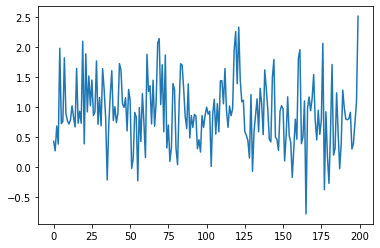

In [42]:
# check if it works :)
g = Generator()
bait = torch.randn(1,3,200)
print(g(bait).shape)
plt.plot(g(bait).detach().squeeze());

In [33]:
# Discriminator model as described in paper
# added linear + sigmoid to get classification

class Discriminator(nn.Module):
    
    def __init__(self, seq_len, conv_dropout=0.05):
        super(Discriminator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(1, 80, kernel_size=1, dilation=1, padding=0),
                                  *[TemporalBlock(80, 80, kernel_size=2, dilation=2 ** i, padding=2 ** i) for i in range(6)]])
        self.one = nn.Conv1d(80, 1, kernel_size=1, dilation=1)
        self.to_prob = nn.Sequential(nn.Linear(seq_len, 1), nn.Sigmoid())

    def forward(self, x):
        skips = []
        for layer in self.tcn:
            skip, x = layer(x)
            skips.append(skip)
        x = self.one(x + sum(skips))
        return self.to_prob(x).squeeze()


In [34]:
# check if it works :)
d = Discriminator(180)
bait = torch.randn(1,1,180)
d(bait)

## Training 

In [37]:
# Simple dataset which chunks initial financial time-series
# into smaller sub-time-series of constant length

class TimeseriesLoader(Dataset):
    
    def __init__(self, ts, length):
        assert len(ts) >= length
        self.ts = ts
        self.length = length
        
    def __len__(self):
        return max(len(self.ts)-self.length, 0)
    
    def __getitem__(self, idx):
        return torch.tensor(self.ts[idx:idx+self.length].values).reshape(-1, self.length)
        


In [36]:
# set batch size 
batch_size = 2

In [38]:
# setting dataloader
d1 = data['t_rolling'][126:]
data_loader = DataLoader(TimeseriesLoader(d1, 127), batch_size=batch_size, shuffle=True, drop_last=True)
data_loader.__iter__().next().shape

torch.Size([2, 1, 127])

In [39]:
# helper function to put obj on cuda
def cuda(xs):
    if torch.cuda.is_available():
        if not isinstance(xs, (list, tuple)):
            return xs.cuda()
        else:
            return [x.cuda() for x in xs]

In [40]:
# setting hyperparams there
# I noticed model is Really sensetive to hparams, activation values, optimizer used and its hparams also.
epochs = 100
lr = 0.00004 
ts_len = 127

In [41]:
# Training process here 
# I use AdamW optimizer with custom weight decay, BCELoss and also added grad clipping to make it a bit more stable
# In the end both models saved to a two .pt files 

D = Discriminator(ts_len)
G = Generator()
bce = nn.BCELoss()

cuda([D, G, bce])

D_loss = []
G_loss = []

d_optimizer = torch.optim.AdamW(D.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.03)
g_optimizer = torch.optim.AdamW(G.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.03)

for epoch in range(epochs):
    D_ls = []
    G_ls = []
    for i, ts in enumerate(data_loader):
        # set train
        G.train()
        ts = Variable(ts).float()
        bs = ts.size(0)
        z = Variable(torch.randn(bs, 3, ts_len))
        r_lbl = Variable(torch.ones(bs))
        f_lbl = Variable(torch.zeros(bs))
        ts, z, r_lbl, f_lbl = cuda([ts, z, r_lbl, f_lbl])
        
        f_ts = G(z)

        # train D
        r_logit = D(ts)
        f_logit = D(f_ts.detach())

        d_r_loss = bce(r_logit, r_lbl)
        d_f_loss = bce(f_logit, f_lbl)
        d_loss = d_r_loss + d_f_loss
        D_ls.append(d_loss.item())
    
        D.zero_grad()
        d_loss.backward()
        torch.nn.utils.clip_grad_value_(D.parameters(), 1) #!!
        d_optimizer.step()
        
        # train G
        f_logit = D(f_ts)
        g_loss = bce(f_logit, r_lbl)
        G_ls.append(g_loss.item())

        D.zero_grad()
        G.zero_grad()
        g_loss.backward()
        torch.nn.utils.clip_grad_value_(G.parameters(), 1) #!!
        g_optimizer.step()
        

    D_loss.append(np.mean(D_ls))
    G_loss.append(np.mean(G_ls))
    print(f'Epoch {epoch}, Discriminator loss:{np.mean(D_ls)}, Generator loss:{np.mean(G_ls)}')
torch.save(G, 'QuantGenerator.pt')
torch.save(D, 'QuantDiscriminator.pt')
print('Training complete, model saved!')

Epoch 0, Discriminator loss:0.8785715941029291, Generator loss:1.5072385368454788
Epoch 1, Discriminator loss:0.4740256946240724, Generator loss:2.695911942877703
Epoch 2, Discriminator loss:0.3394922051877883, Generator loss:4.158982215504404
Epoch 3, Discriminator loss:0.42494929657744557, Generator loss:3.9169351138588455
Epoch 4, Discriminator loss:0.5613928109652113, Generator loss:3.292463861424821
Epoch 5, Discriminator loss:0.6203225943392479, Generator loss:2.8451377519751313
Epoch 6, Discriminator loss:0.701475256976361, Generator loss:2.669831155875215
Epoch 7, Discriminator loss:0.7747823300409235, Generator loss:2.0985705599878672
Epoch 8, Discriminator loss:0.8814743445927484, Generator loss:1.8133139187056158
Epoch 9, Discriminator loss:0.9659149555260363, Generator loss:1.7168567637257555
Epoch 10, Discriminator loss:1.0101147139306974, Generator loss:1.387341386038396
Epoch 11, Discriminator loss:1.045024220669573, Generator loss:1.312465077445463
Epoch 12, Discriminat

## Evaluation

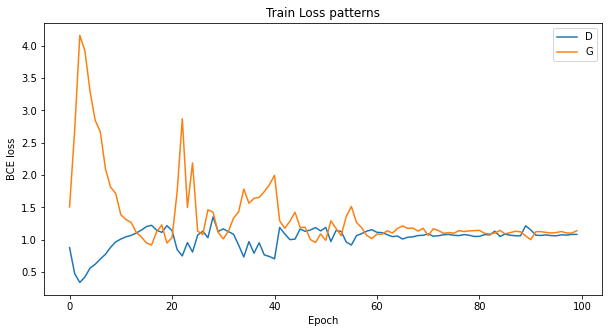

In [105]:
# training loss patterns look quite wild but also characteristic for GAN's
plt.plot(D_loss, label='D');
plt.plot(G_loss, label='G');
plt.xlabel('Epoch')
plt.ylabel('BCE loss') 
plt.title('Train Loss patterns')
plt.legend();

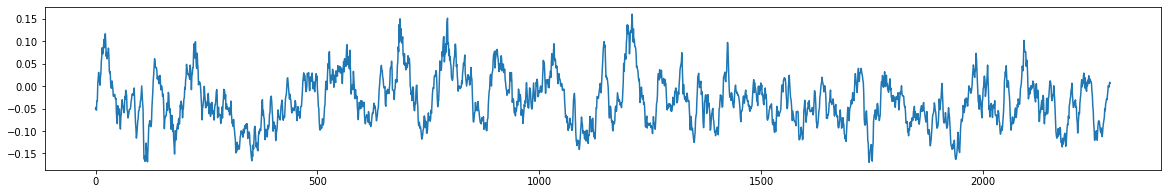

In [104]:
# looking at sample log-paths
bait = torch.randn(1,3,len(data['t_rolling'])-127).cuda()
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(G(bait).cpu().detach().squeeze());
plt.rcParams["figure.figsize"] =  (10,5)

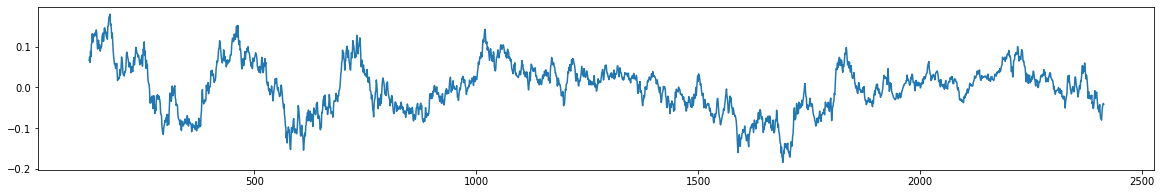

In [100]:
# looking at original S&P500 data log-paths
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(data['t_rolling'][127:])
plt.rcParams["figure.figsize"] = (10,5)

In [88]:
bait = torch.randn(1,3,2288).cuda()
val = (G(bait).cpu().detach().squeeze())

In [ ]:
# EM distance

wasserstein_distance(val, data['t_rolling'][126:])

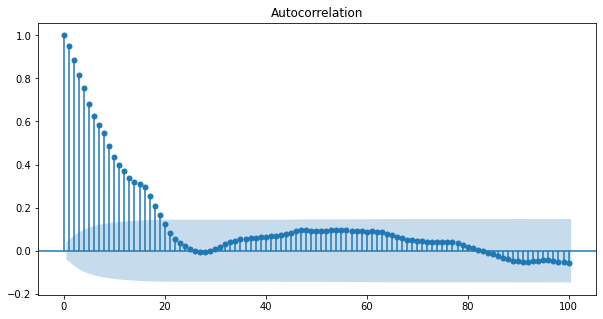

In [93]:
# acf graph for generated log path
sm.graphics.tsa.plot_acf(val, lags=100, adjusted=True);